In [1]:
pip install "numpy<2.0"


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.templates.default = "plotly_white"



In [10]:
data = pd.read_csv("rfm_data.csv")
print(data.head())

   CustomerID PurchaseDate  TransactionAmount ProductInformation  OrderID  \
0        8814   2023-04-11             943.31          Product C   890075   
1        2188   2023-04-11             463.70          Product A   176819   
2        4608   2023-04-11              80.28          Product A   340062   
3        2559   2023-04-11             221.29          Product A   239145   
4        9482   2023-04-11             739.56          Product A   194545   

   Location  
0     Tokyo  
1    London  
2  New York  
3    London  
4     Paris  


In [68]:
from datetime import datetime

data['PurchaseDate'] = pd.to_datetime(data['PurchaseDate'])

data['Recency'] = (pd.Timestamp.now() - data['PurchaseDate']).dt.days

frequency_data = data.groupby('CustomerID')['OrderID'].count().reset_index()
frequency_data.rename(columns={'OrderID': 'Frequency'}, inplace=True)
data = data.merge(frequency_data, on='CustomerID', how='left')

monetary_data = data.groupby('CustomerID')['TransactionAmount'].sum().reset_index()
monetary_data.rename(columns={'TransactionAmount': 'MonetaryValue'}, inplace=True)
data = data.merge(monetary_data, on='CustomerID', how='left')

In [16]:
print(data.head())

   CustomerID PurchaseDate  TransactionAmount ProductInformation  OrderID  \
0        8814   2023-04-11             943.31          Product C   890075   
1        2188   2023-04-11             463.70          Product A   176819   
2        4608   2023-04-11              80.28          Product A   340062   
3        2559   2023-04-11             221.29          Product A   239145   
4        9482   2023-04-11             739.56          Product A   194545   

   Location  Recency  Frequency  MonetaryValue  
0     Tokyo      785          1         943.31  
1    London      785          1         463.70  
2  New York      785          1          80.28  
3    London      785          1         221.29  
4     Paris      785          1         739.56  


In [66]:
recency_scores = [5, 4, 3, 2, 1]  # Higher score for lower recency (more recent)
frequency_scores = [1, 2, 3, 4, 5]  # Higher score for higher frequency
monetary_scores = [1, 2, 3, 4, 5] 

data['RecencyScore'] = pd.cut(data['Recency'], bins=5, labels=recency_scores)
data['FrequencyScore'] = pd.cut(data['Frequency'], bins=5, labels=frequency_scores)
data['MonetaryScore'] = pd.cut(data['MonetaryValue'], bins=5, labels=monetary_scores)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   CustomerID          1000 non-null   int64         
 1   PurchaseDate        1000 non-null   datetime64[ns]
 2   TransactionAmount   1000 non-null   float64       
 3   ProductInformation  1000 non-null   object        
 4   OrderID             1000 non-null   int64         
 5   Location            1000 non-null   object        
 6   Recency             1000 non-null   int64         
 7   Frequency           1000 non-null   int64         
 8   MonetaryValue       1000 non-null   float64       
 9   RecencyScore        1000 non-null   category      
 10  FrequencyScore      1000 non-null   category      
 11  MonetaryScore       1000 non-null   category      
dtypes: category(3), datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 74.0+ KB


In [62]:
data['RecencyScore'] = data['RecencyScore'].astype(int)
data['FrequencyScore'] = data['FrequencyScore'].astype(int)
data['MonetaryScore'] = data['MonetaryScore'].astype(int)

In [64]:
data['RFM_Score'] = data['RecencyScore'] + data['FrequencyScore'] + data['MonetaryScore']

segment_labels = ['Low-Value', 'Mid-Value', 'High-Value']
data['Value Segment'] = pd.qcut(data['RFM_Score'], q=3, labels=segment_labels)

In [28]:
print(data.head())

   CustomerID PurchaseDate  TransactionAmount ProductInformation  OrderID  \
0        8814   2023-04-11             943.31          Product C   890075   
1        2188   2023-04-11             463.70          Product A   176819   
2        4608   2023-04-11              80.28          Product A   340062   
3        2559   2023-04-11             221.29          Product A   239145   
4        9482   2023-04-11             739.56          Product A   194545   

   Location  Recency  Frequency  MonetaryValue  RecencyScore  FrequencyScore  \
0     Tokyo      785          1         943.31             1               1   
1    London      785          1         463.70             1               1   
2  New York      785          1          80.28             1               1   
3    London      785          1         221.29             1               1   
4     Paris      785          1         739.56             1               1   

   MonetaryScore  RFM_Score Value Segment  
0           

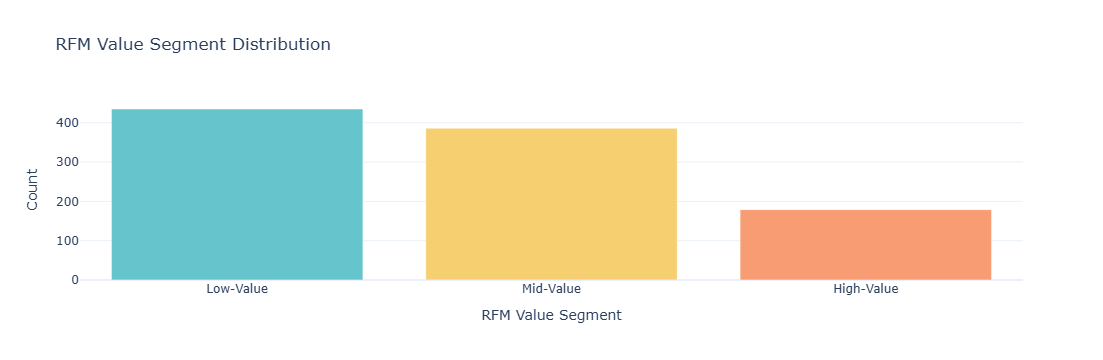

In [58]:
segment_counts = data['Value Segment'].value_counts().reset_index()
segment_counts.columns = ['Value Segment', 'Count']

pastel_colors = px.colors.qualitative.Pastel

fig_segment_dist = px.bar(segment_counts, x='Value Segment', y='Count', 
                          color='Value Segment', color_discrete_sequence=pastel_colors,
                          title='RFM Value Segment Distribution')

fig_segment_dist.update_layout(xaxis_title='RFM Value Segment',
                              yaxis_title='Count',
                              showlegend=False)

fig_segment_dist.show()

In [56]:
data['RFM Customer Segments'] = ''

data.loc[data['RFM_Score'] >= 9, 'RFM Customer Segments'] = 'Champions'
data.loc[(data['RFM_Score'] >= 6) & (data['RFM_Score'] < 9), 'RFM Customer Segments'] = 'Potential Loyalists'
data.loc[(data['RFM_Score'] >= 5) & (data['RFM_Score'] < 6), 'RFM Customer Segments'] = 'At Risk Customers'
data.loc[(data['RFM_Score'] >= 4) & (data['RFM_Score'] < 5), 'RFM Customer Segments'] = "Can't Lose"
data.loc[(data['RFM_Score'] >= 3) & (data['RFM_Score'] < 4), 'RFM Customer Segments'] = "Lost"

print(data[['CustomerID', 'RFM Customer Segments']])

     CustomerID RFM Customer Segments
0          8814            Can't Lose
1          2188                  Lost
2          4608                  Lost
3          2559                  Lost
4          9482            Can't Lose
..          ...                   ...
995        2970   Potential Loyalists
996        6669   Potential Loyalists
997        8836   Potential Loyalists
998        1440   Potential Loyalists
999        4759   Potential Loyalists

[1000 rows x 2 columns]


C:\Users\vaibh\AppData\Local\Temp\ipykernel_36744\1723423643.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\vaibh\anaconda3\Lib\site-packages\plotly\express\_core.py:1706: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\vaibh\anaconda3\Lib\site-packages\plotly\express\_core.py:1706: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



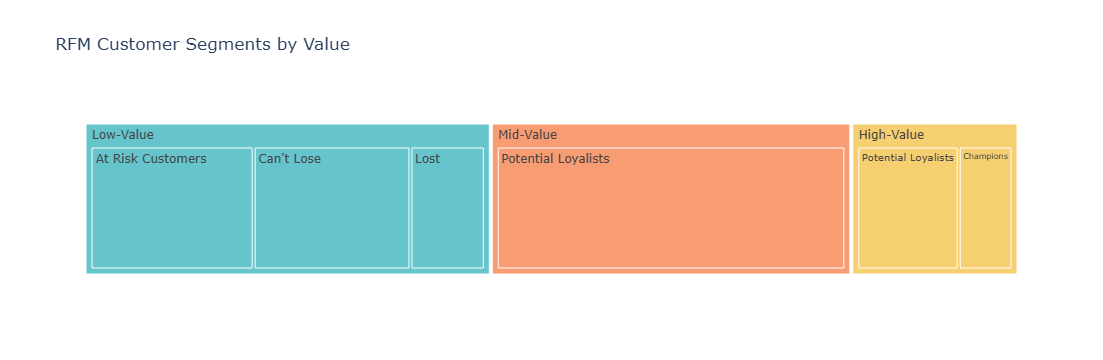

In [34]:
segment_product_counts = data.groupby(['Value Segment', 'RFM Customer Segments']).size().reset_index(name='Count')

segment_product_counts = segment_product_counts.sort_values('Count', ascending=False)

fig_treemap_segment_product = px.treemap(segment_product_counts, 
                                         path=['Value Segment', 'RFM Customer Segments'], 
                                         values='Count',
                                         color='Value Segment', color_discrete_sequence=px.colors.qualitative.Pastel,
                                         title='RFM Customer Segments by Value')
fig_treemap_segment_product.show()

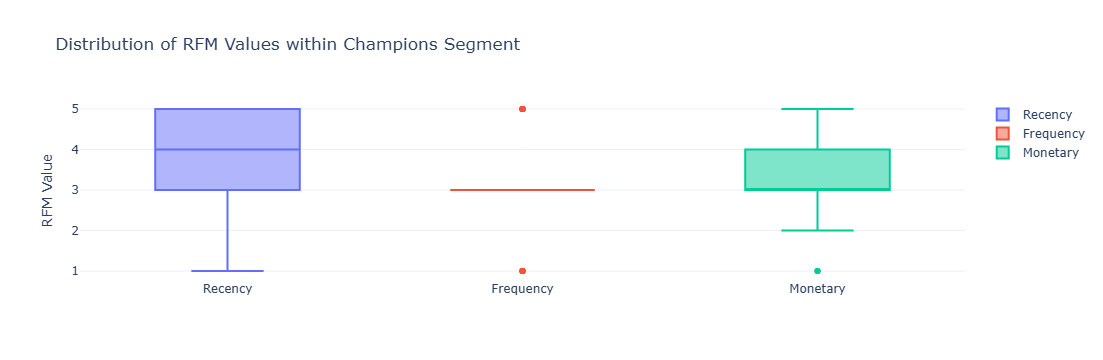

In [36]:
champions_segment = data[data['RFM Customer Segments'] == 'Champions']

fig = go.Figure()
fig.add_trace(go.Box(y=champions_segment['RecencyScore'], name='Recency'))
fig.add_trace(go.Box(y=champions_segment['FrequencyScore'], name='Frequency'))
fig.add_trace(go.Box(y=champions_segment['MonetaryScore'], name='Monetary'))

fig.update_layout(title='Distribution of RFM Values within Champions Segment',
                  yaxis_title='RFM Value',
                  showlegend=True)

fig.show()

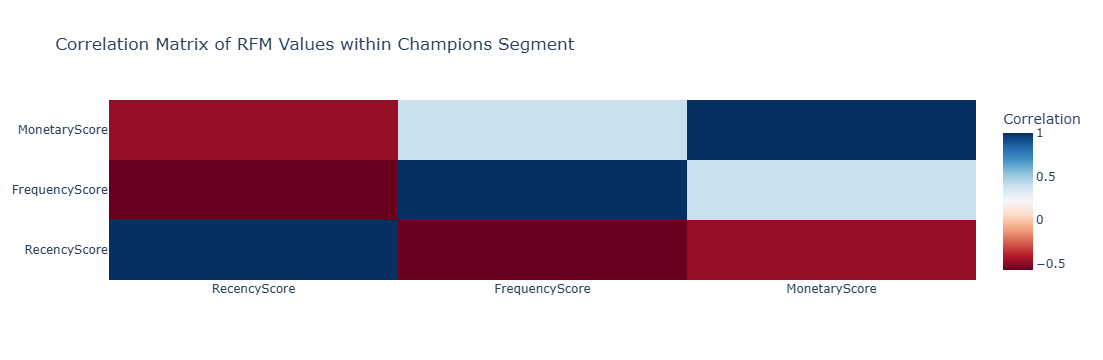

In [54]:
correlation_matrix = champions_segment[['RecencyScore', 'FrequencyScore', 'MonetaryScore']].corr()

fig_heatmap = go.Figure(data=go.Heatmap(
                   z=correlation_matrix.values,
                   x=correlation_matrix.columns,
                   y=correlation_matrix.columns,
                   colorscale='RdBu',
                   colorbar=dict(title='Correlation')))

fig_heatmap.update_layout(title='Correlation Matrix of RFM Values within Champions Segment')

fig_heatmap.show()

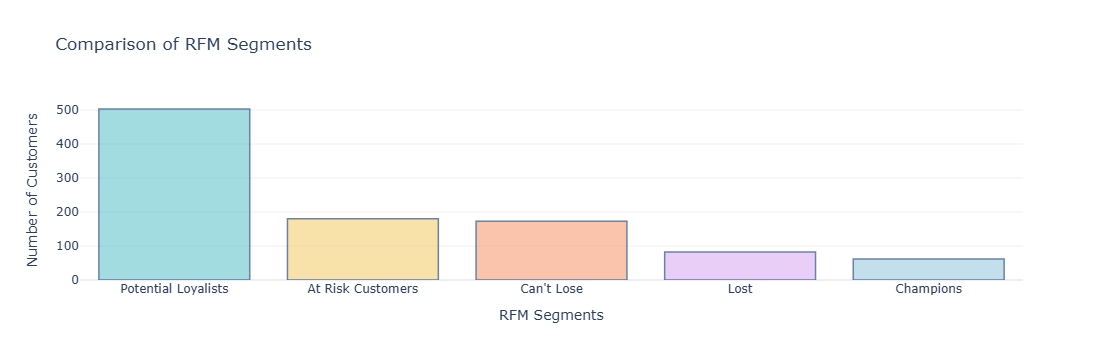

In [52]:
import plotly.colors

pastel_colors = plotly.colors.qualitative.Pastel

segment_counts = data['RFM Customer Segments'].value_counts()

fig = go.Figure(data=[go.Bar(x=segment_counts.index, y=segment_counts.values,
                            marker=dict(color=pastel_colors))])

champions_color = 'rgb(158, 202, 225)'
fig.update_traces(marker_color=[champions_color if segment == 'Champions' else pastel_colors[i]
                                for i, segment in enumerate(segment_counts.index)],
                  marker_line_color='rgb(8, 48, 107)',
                  marker_line_width=1.5, opacity=0.6)

fig.update_layout(title='Comparison of RFM Segments',
                  xaxis_title='RFM Segments',
                  yaxis_title='Number of Customers',
                  showlegend=False)

fig.show()

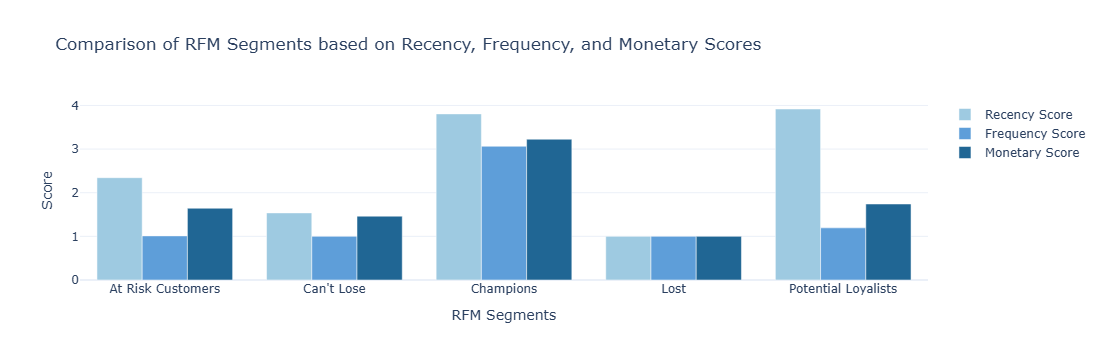

In [50]:
segment_scores = data.groupby('RFM Customer Segments')[['RecencyScore', 'FrequencyScore', 'MonetaryScore']].mean().reset_index()

fig = go.Figure()

fig.add_trace(go.Bar(
    x=segment_scores['RFM Customer Segments'],
    y=segment_scores['RecencyScore'],
    name='Recency Score',
    marker_color='rgb(158,202,225)'
))

fig.add_trace(go.Bar(
    x=segment_scores['RFM Customer Segments'],
    y=segment_scores['FrequencyScore'],
    name='Frequency Score',
    marker_color='rgb(94,158,217)'
))


fig.add_trace(go.Bar(
    x=segment_scores['RFM Customer Segments'],
    y=segment_scores['MonetaryScore'],
    name='Monetary Score',
    marker_color='rgb(32,102,148)'
))


fig.update_layout(
    title='Comparison of RFM Segments based on Recency, Frequency, and Monetary Scores',
    xaxis_title='RFM Segments',
    yaxis_title='Score',
    barmode='group',
    showlegend=True
)

fig.show()